# Coursera Capstone Project

## Introduction
<font color=blue>Besides coffee, milk tea becomes a popular beverage now. We plan to open a tea shop in San Diego, CA. There are many neighborhoods in San Diego city and the retail rental price varies among them.  So first we need to look for some neighborhoods already have good restaurants or cafes people like to go, second, the rental price should not be very high which might be over our budget.

    In this project,
        Step 1: Scrape San Diego neighborhoods and rental market data from website
        Step 2: Obtain the geographical data of each neighborhood
        Step 3: Get the popular venues with Foursquare API
        Step 4: Use K-means to cluster the neighborhoods based on the venues and average rental price
        Step 5: Provide a discussion based on the clustering results
</font>

## Table of Contents
- [1. Download and Explore Dataset](#id-section1)
- [2. Explore Neighborhoods in San Diego City](#id-section2)
- [3. Analyze Each Neighborhood](#id-section3)
- [4. Cluster Neighborhoods](#id-section4)
- [5. Examine Clusters](#id-section5)
- [6. Discussion](#id-section6)


<div id="id-section1"> <font size="6"><b>1.Download and Explore Dataset</b></font></div>

#### Scraping an html to get the list of neighborhoods and the average rental price in San Diego

In [1]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
import requests # library to handle requests
import urllib.request

import pandas as pd #library for data analysis
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 122kB 6.3MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing tran

In [2]:
# I don't use this website anymore, but another having Average Rent prices of each neighborhood in San Diego
# url = 'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'
# response = requests.get(url)
# soup = BeautifulSoup(response.content, 'html.parser')
# div = soup.find("div", {"aria-labelledby":"Neighborhoods_of_San_Diego"})
# results = [li.text for li in div.findAll('li')]

In [3]:
url = 'https://www.rentcafe.com/average-rent-market-trends/us/ca/san-diego/'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
div = soup.find("div", {"class":"table-neighborhood"})

In [4]:
column_names = ['Neighborhoods','AverageRent']
df = pd.DataFrame(columns = column_names)

In [5]:
table = div.find("table", {"id":"MarketTrendsAverageRentTable"})
row = table.findAll("tr", {"class":"current-row"})
row_marker = 0
for row in table.findAll("tr", {"class":"current-row"}):
    df.at[row_marker, 'Neighborhoods'] = row.find('th').text
    df.at[row_marker, 'AverageRent'] = row.find('td').text
    row_marker += 1

In [6]:
df['AverageRent']=df['AverageRent'].map(lambda x: x.lstrip('$'))
df['AverageRent']=df['AverageRent'].str.replace(',','')
df['AverageRent']=pd.to_numeric(df['AverageRent'], downcast='float')

In [7]:
df.loc[df['Neighborhoods'] == 'Clairemont Mesa West', ['Neighborhoods']] = 'Clairemont Mesa'

In [8]:
df.sort_values(by='Neighborhoods',inplace=True)

In [9]:
sd_df = df.reset_index(drop=True)

In [10]:
print("There are " + str(sd_df.shape[0]) + " neighborhoods in San Diego")

There are 122 neighborhoods in San Diego


In [11]:
#add two columns for Latitude and Longitude
sd_df['Latitude']=''
sd_df['Longitude']=''

In [12]:
sd_df.head()

,Neighborhoods,AverageRent,Latitude,Longitude
0,4S Ranch,2261.0,,
1,Allied Gardens,2105.0,,
2,Alta Vista,975.0,,
3,Alvarado Estates,1946.0,,
4,Azalea - Hollywood Park,1619.0,,


In [13]:
#geocoder.google doesn't work, no return
#!pip install geocoder
#import geocoder
#lat_lng_coords = None
#while (lat_lng_coords is None):
#    g = geocoder.google('San Diego, CA')
#    lat_lng_coords = g.latlng

#latitude=lat_lng_coords[0]
#longitude=lat_lng_coords[1]

In [14]:
suffix = ', San Diego, CA'
row_marker = 0
for nghb in sd_df['Neighborhoods']:
    address = nghb + suffix
    geolocator = Nominatim(user_agent='SD_explorer')
    location = geolocator.geocode(address)
    if location != None:
        sd_df.at[row_marker, 'Latitude'] = location.latitude
        sd_df.at[row_marker, 'Longitude'] = location.longitude
    else:
        sd_df.at[row_marker, 'Latitude'] = None
        sd_df.at[row_marker, 'Longitude'] = None
    row_marker += 1


In [15]:
sd_df['Latitude']=pd.to_numeric(sd_df['Latitude'], downcast='float')
sd_df['Longitude']=pd.to_numeric(sd_df['Longitude'], downcast='float')
sd_df.dtypes

Neighborhoods     object
AverageRent      float32
Latitude         float32
Longitude        float32
dtype: object

In [16]:
nan_returns = sd_df['Latitude'].isnull().sum(axis = 0)
print("There are {} neighborhoods without Latitude and Longitude value returned".format(nan_returns))

There are 25 neighborhoods without Latitude and Longitude value returned


In [17]:
sd_df.head()

,Neighborhoods,AverageRent,Latitude,Longitude
0,4S Ranch,2261.0,NaN,NaN
1,Allied Gardens,2105.0,32.792686,-117.080437
2,Alta Vista,975.0,32.693340,-117.063156
3,Alvarado Estates,1946.0,32.774399,-117.091347
4,Azalea - Hollywood Park,1619.0,33.368637,-117.175911


<font>Not all neighborhoods' geographical parameters can be obtained, so I will try different name for those neighborhoods and delete those that I can't get the latitude and longitude at the end</font>

In [18]:
#drop the neighborhoods without latitude and longitude
sd_df=sd_df.dropna()
sd_df=sd_df.reset_index(drop=True)
sd_df.shape

(97, 4)

In [19]:
sd_df.head()

,Neighborhoods,AverageRent,Latitude,Longitude
0,Allied Gardens,2105.0,32.792686,-117.080437
1,Alta Vista,975.0,32.693340,-117.063156
2,Alvarado Estates,1946.0,32.774399,-117.091347
3,Azalea - Hollywood Park,1619.0,33.368637,-117.175911
4,Balboa Park,2411.0,32.731358,-117.146530


<font>Till now, I already have the clean dataset for exploring and cluster later.</font>

#### Create a map of San Diego with neighborhoods superimposed on top.

In [20]:
# create map of San Diego using latitude and longitude values
address = 'San Diego, CA'
geolocator = Nominatim(user_agent='SD_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_sandiego = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, nghbd in zip(sd_df['Latitude'], sd_df['Longitude'], sd_df['Neighborhoods']):
    label = '{}'.format(nghbd)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sandiego)  
    
map_sandiego

<div id="id-section2"> <font size="6"><b>2. Explore Neighborhoods in San Diego</b></font></div>

#### Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = 'SCIUXMLEPZJKICI1VOHG3TKUYIHTGO13DUBN3HB1NQIT40MH' # your Foursquare ID
CLIENT_SECRET = '5GEFSDBCOLVV2ZETXFOTAY5M4AHMBPFV0CINCL1HJ5MP1XL4' # your Foursquare Secret
VERSION = '20200625' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SCIUXMLEPZJKICI1VOHG3TKUYIHTGO13DUBN3HB1NQIT40MH
CLIENT_SECRET:5GEFSDBCOLVV2ZETXFOTAY5M4AHMBPFV0CINCL1HJ5MP1XL4


#### Create a function to repeat the same process to all the neighborhoods in San Diego

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    LIMIT = 100
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
               
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now run the above function on each neighborhood and create a new dataframe called *sd_venues*.

In [23]:
sd_venues = getNearbyVenues(names=sd_df['Neighborhoods'],
                            latitudes=sd_df['Latitude'],
                            longitudes=sd_df['Longitude'],
                            radius=600
                            )

Allied Gardens
Alta Vista
Alvarado Estates
Azalea - Hollywood Park
Balboa Park
Bankers Hill - Park West
Barrio Logan
Bay Park
Bay Terraces
Birdland
Black Mountain Ranch
Broadway Heights
Burlingame
Carmel Mountain
Carmel Valley
Castle
Cherokee Point
Chollas Creek
Chollas View
Clairemont Mesa
Corridor
Cortez
Del Cerro
East Village
El Cerrito
Emerald Hills
Encanto
Fairmount Village
Fleet Ridge
Fox Canyon
Gaslamp
Golden Hill
Grant Hill
Grantville
Harborview
Hillcrest
Horton Plaza
Islenair
Jamacha Lomita
Kearny Mesa
La Playa
Lincoln Park
Linda Vista
Little Italy
Logan Heights
Loma Portal
Marina
Midway
Mira Mesa
Miramar
Miramar Ranch
Mission Bay
Mission Beach
Mission Hills
Mission Hills South
Mission Valley West
Morena
Mount Hope
Mountain View
Nestor
North Clairemont
North Park
Oak Park
Ocean Beach
Old Town San Diego
Otay Mesa
Otay Mesa West
Pacific Beach
Palm City
Paradise Hills
Petco Park
Rancho Bernardo
Rancho Penasquitos
Rolando
Rolando Park
Sabre Springs
San Carlos
Santa Fe Valley
Scrip

In [24]:
sd_venues.head()

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allied Gardens,32.792686,-117.080437,Heavenly Donuts,32.791584,-117.082278,Donut Shop
1,Allied Gardens,32.792686,-117.080437,Mona Lisa Italian Foods,32.792044,-117.081912,Italian Restaurant
2,Allied Gardens,32.792686,-117.080437,Fosters Freeze,32.790677,-117.081386,Burger Joint
3,Allied Gardens,32.792686,-117.080437,El Rodeo Taco Shop & Grill,32.791015,-117.081001,Mexican Restaurant
4,Allied Gardens,32.792686,-117.080437,7-Eleven,32.791275,-117.082641,Convenience Store


In [25]:
sd_venues.groupby('Neighborhoods').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhoods,,,,,,
Allied Gardens,20,20,20,20,20,20
Alta Vista,1,1,1,1,1,1
Azalea - Hollywood Park,2,2,2,2,2,2
Balboa Park,80,80,80,80,80,80
Bankers Hill - Park West,39,39,39,39,39,39
Barrio Logan,29,29,29,29,29,29
Bay Park,17,17,17,17,17,17
Bay Terraces,3,3,3,3,3,3
Birdland,4,4,4,4,4,4


In [26]:
len(sd_venues['Neighborhoods'].unique())

95

#### Let's find out how many unique categories can be curated from all the returned venues

In [27]:
print('There are {} unique categories.'.format(len(sd_venues['Venue Category'].unique())))

There are 283 unique categories.


<div id="id-section3"> <font size="6"><b>3. Analyze Each Neighborhood</b></font></div>

In [28]:
# one hot encoding
sd_onehot = pd.get_dummies(sd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sd_onehot['Neighborhoods'] = sd_venues['Neighborhoods'] 

# move neighborhood column to the first column
fixed_columns = [sd_onehot.columns[-1]] + list(sd_onehot.columns[:-1])
sd_onehot = sd_onehot[fixed_columns]

sd_onehot.head()

,Neighborhoods,ATM,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Middle School,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store

In [29]:
sd_onehot.shape

(2633, 284)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
sd_grouped = sd_onehot.groupby('Neighborhoods').mean().reset_index()
sd_grouped

,Neighborhoods,ATM,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Middle School,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store

In [31]:
sd_grouped['AverageRent']=sd_df['AverageRent']
# move AverageRent column to the second column, method1
avgrent = sd_grouped['AverageRent']
sd_grouped.drop(labels=['AverageRent'], axis=1, inplace=True)
sd_grouped.insert(1,'AverageRent',avgrent)
# move AverageRent column to the second column, method2
#fixed_columns = [sd_grouped.columns[0]] + [sd_grouped.columns[-1]] + list(sd_grouped.columns[2:-1])
#sd_grouped = sd_grouped[fixed_columns]


In [32]:
print('Size of sd_grouped: ', sd_grouped.shape[0])
sd_grouped.head()

Size of sd_grouped:  95


,Neighborhoods,AverageRent,ATM,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Middle School,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tour Provider,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,W

#### Let's print each neighborhood along with the top 10 most common venues

In [33]:
num_top_venues = 10

for hood in sd_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = sd_grouped[sd_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allied Gardens----
                  venue  freq
0                  Park  0.10
1    Mexican Restaurant  0.10
2           Gas Station  0.05
3           Pizza Place  0.05
4            Sports Bar  0.05
5            Donut Shop  0.05
6                Office  0.05
7          Optical Shop  0.05
8         Grocery Store  0.05
9  Gym / Fitness Center  0.05


----Alta Vista----
                           venue  freq
0                            Gym   1.0
1                            ATM   0.0
2                    Music Store   0.0
3                      Pawn Shop   0.0
4                           Park   0.0
5  Paper / Office Supplies Store   0.0
6                Paintball Field   0.0
7              Outdoor Sculpture   0.0
8              Other Repair Shop   0.0
9                   Optical Shop   0.0


----Azalea - Hollywood Park----
                           venue  freq
0                  Garden Center   0.5
1                            Gym   0.5
2                            ATM   0.0
3      

#### Let's put that into a *pandas* dataframe

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[0:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods', 'AverageRent']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] =sd_grouped['Neighborhoods']
neighborhoods_venues_sorted['AverageRent'] =sd_grouped['AverageRent']

for ind in np.arange(sd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(sd_grouped.iloc[ind, 2:], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,AverageRent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allied Gardens,2105.0,Park,Mexican Restaurant,Shipping Store,Optical Shop,Grocery Store,Burger Joint,Gym / Fitness Center,Liquor Store,Gas Station,Office
1,Alta Vista,975.0,Gym,Zoo Exhibit,Fondue Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Farmers Market
2,Azalea - Hollywood Park,1946.0,Garden Center,Gym,Zoo Exhibit,Fondue Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food
3,Balboa Park,1619.0,Zoo Exhibit,Theater,Garden,Art Museum,Gift Shop,History Museum,Performing Arts Venue,Park,Tour Provider,Zoo
4,Bankers Hill - Park West,2411.0,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Bridge,Soccer Field,Lounge,Gastropub


<div id="id-section4"> <font size="6"><b>4. Cluster Neighborhoods</b></font></div>

<font>Find the optimal K with elbow method</font>

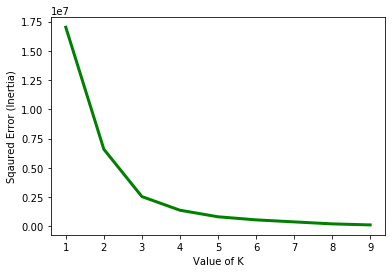

In [36]:
import matplotlib.pyplot as plt
# set number of clusters
K = 10
inertias=[]
sd_grouped_clustering = sd_grouped.drop('Neighborhoods', 1)

for kclusters in range(1, K):
    # run k-means clustering
    kmeans = KMeans(init='k-means++', n_clusters=kclusters, random_state=0).fit(sd_grouped_clustering)
    inertias.append(kmeans.inertia_)

# plot the inertia against K values 
plt.plot(range(1, K),inertias, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Inertia)") 
plt.show() # clear the plot     


<font>Choose K value based on the above curve</font>

In [37]:

# set number of clusters
K = 4
# run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters=K, random_state=0).fit(sd_grouped_clustering)
kmeans.labels_


array([0, 1, 0, 3, 2, 2, 1, 0, 3, 2, 2, 1, 3, 0, 2, 3, 3, 3, 3, 3, 3, 2,
       0, 2, 0, 1, 1, 3, 0, 3, 2, 3, 3, 2, 2, 0, 2, 3, 1, 0, 0, 3, 3, 2,
       1, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 3, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 3, 1, 0, 3, 1, 3, 0,
       0, 2, 0, 2, 2, 2, 3], dtype=int32)

Let's create a new dataframe that includes the cluster, the top 10 venues, average rent, latitude and longitude for each neighborhood.

In [38]:
sd_venues_ll = sd_venues.groupby(['Neighborhoods', 'Neighborhood Latitude', 'Neighborhood Longitude']).size()
sd_venues_df = sd_venues_ll.to_frame().reset_index()
sd_venues_df = sd_venues_df.iloc[:, :-1]
sd_venues_df.head()

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude
0,Allied Gardens,32.792686,-117.080437
1,Alta Vista,32.693340,-117.063156
2,Azalea - Hollywood Park,33.368637,-117.175911
3,Balboa Park,32.731358,-117.146530
4,Bankers Hill - Park West,32.732655,-117.162392


In [39]:
sd_venues_df.columns = ['Neighborhoods', 'Latitude', 'Longitude']

In [40]:
sd_venues_df.head()

,Neighborhoods,Latitude,Longitude
0,Allied Gardens,32.792686,-117.080437
1,Alta Vista,32.693340,-117.063156
2,Azalea - Hollywood Park,33.368637,-117.175911
3,Balboa Park,32.731358,-117.146530
4,Bankers Hill - Park West,32.732655,-117.162392


In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sd_merged = sd_venues_df

# add latitude/longitude for each neighborhood
sd_merged = sd_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhoods')

sd_merged.head() # check the last columns!

,Neighborhoods,Latitude,Longitude,Cluster Labels,AverageRent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allied Gardens,32.792686,-117.080437,0,2105.0,Park,Mexican Restaurant,Shipping Store,Optical Shop,Grocery Store,Burger Joint,Gym / Fitness Center,Liquor Store,Gas Station,Office
1,Alta Vista,32.693340,-117.063156,1,975.0,Gym,Zoo Exhibit,Fondue Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Farmers Market
2,Azalea - Hollywood Park,33.368637,-117.175911,0,1946.0,Garden Center,Gym,Zoo Exhibit,Fondue Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food
3,Balboa Park,32.731358,-117.146530,3,1619.0,Zoo Exhibit,Theater,Garden,Art Museum,Gift Shop,History Museum,Performing Arts Venue,Park,Tour Provider,Zoo
4,Bankers Hill - Park West,32.732655,-117.162392,2,2411.0,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Bridge,Soccer Field,Lounge,Gastropub


Finally, let's visualize the resulting clusters in the map

In [42]:
# create map of San Diego using latitude and longitude values
address = 'San Diego, CA'
geolocator = Nominatim(user_agent='SD_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 4
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sd_merged['Latitude'], sd_merged['Longitude'], sd_merged['Neighborhoods'], sd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
           
map_clusters

In [43]:
sd_merged.shape

(95, 15)

In [44]:
sd_merged.head()

,Neighborhoods,Latitude,Longitude,Cluster Labels,AverageRent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allied Gardens,32.792686,-117.080437,0,2105.0,Park,Mexican Restaurant,Shipping Store,Optical Shop,Grocery Store,Burger Joint,Gym / Fitness Center,Liquor Store,Gas Station,Office
1,Alta Vista,32.693340,-117.063156,1,975.0,Gym,Zoo Exhibit,Fondue Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Farmers Market
2,Azalea - Hollywood Park,33.368637,-117.175911,0,1946.0,Garden Center,Gym,Zoo Exhibit,Fondue Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food
3,Balboa Park,32.731358,-117.146530,3,1619.0,Zoo Exhibit,Theater,Garden,Art Museum,Gift Shop,History Museum,Performing Arts Venue,Park,Tour Provider,Zoo
4,Bankers Hill - Park West,32.732655,-117.162392,2,2411.0,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Bridge,Soccer Field,Lounge,Gastropub


<div id="id-section5"> <font size="6"><b>5. Examine the clusters</b></font></div>

<font>Visualize the average rent of each cluster</font>

In [45]:
cluster_rent = sd_merged[['Cluster Labels', 'AverageRent']]
mean_rent = cluster_rent.groupby('Cluster Labels').mean()
print("Average Rent for each cluster: \n ", mean_rent)


Average Rent for each cluster: 
                  AverageRent
Cluster Labels             
0               1987.088257
1               1088.636353
2               2413.846191
3               1667.208374


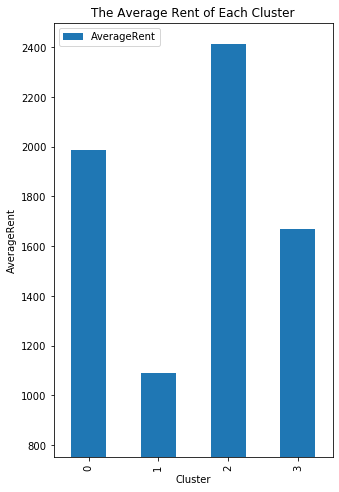

In [46]:
# generate bar chart

mean_rent.plot(kind='bar', figsize=(5, 8))
x1,x2,y1,y2=plt.axis()
plt.axis([x1,x2,750,2500])
plt.title('The Average Rent of Each Cluster')
plt.ylabel('AverageRent')
plt.xlabel('Cluster')

plt.show()

In [47]:
mean_rent.reset_index(inplace=True)
mean_rent

,Cluster Labels,AverageRent
0,0,1987.088257
1,1,1088.636353
2,2,2413.846191
3,3,1667.208374


<font size='4'>Get the statistics of each cluster and list the top 3 venues in the first three Most Common Venue</font>

In [48]:
column=['Cluster Lables','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']
cluster_stat=pd.DataFrame(columns = column)

<font>Manage Cluster 0</font>

In [49]:
cluster0_df = sd_merged.loc[sd_merged['Cluster Labels'] == 0, sd_merged.columns[list(range(5, sd_merged.shape[1]))]]
cluster0_df.describe()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,34,34,34,34,34,34,34,34,34,34
unique,25,28,27,26,21,26,26,27,23,23
top,Mexican Restaurant,Mexican Restaurant,Zoo Exhibit,Fondue Restaurant,Coffee Shop,Liquor Store,Mexican Restaurant,Park,Spa,Flower Shop
freq,4,4,3,3,4,4,3,2,4,3


In [50]:
N=3
for i in range(N):
    temp_df=cluster0_df.iloc[:,i].value_counts().head(3)
    temp_df=temp_df.to_frame()
    temp_df.reset_index(inplace=True)
    temp_df.columns=['Venues','Freq']
    cluster_stat.iloc[:,i+1]=temp_df['Venues']
    cluster_stat.iloc[i,0]=0

In [51]:
cluster_stat

,Cluster Lables,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,0,Mexican Restaurant,Mexican Restaurant,Zoo Exhibit
1,0,Home Service,Park,Gym / Fitness Center
2,0,Furniture / Home Store,Boutique,Coffee Shop


In [52]:
#c0_stat=cluster0_df.describe().loc[['top']]
#c0_stat.reset_index(inplace=True)
#c0_stat=c0_stat[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]
#c0_stat.insert(loc=0, column='Cluster Labels', value = 0)
#cluster_stat=c0_stat
#cluster_stat

<font>Manage Cluster 1</font>

In [53]:
cluster1_df=sd_merged.loc[sd_merged['Cluster Labels'] == 1, sd_merged.columns[list(range(5, sd_merged.shape[1]))]]
cluster1_df.describe()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,11,11,11,11,11,11,11,11,11,11
unique,8,9,11,11,11,10,11,11,11,11
top,Mexican Restaurant,Convenience Store,Mexican Restaurant,Auto Workshop,Mexican Restaurant,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Fast Food Restaurant
freq,2,2,1,1,1,2,1,1,1,1


In [54]:
N=3
column=['Cluster Lables','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']
c1_stat_df=pd.DataFrame(columns = column)
for i in range(N):
    temp_df=cluster1_df.iloc[:,i].value_counts().head(3)
    temp_df=temp_df.to_frame()
    temp_df.reset_index(inplace=True)
    temp_df.columns=['Venues','Freq']
    c1_stat_df.iloc[:,i+1]=temp_df['Venues']
    c1_stat_df.iloc[i,0]=1

In [55]:
c1_stat_df

,Cluster Lables,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,1,Mexican Restaurant,Convenience Store,Mexican Restaurant
1,1,Hotel,Café,Fondue Restaurant
2,1,Intersection,Mexican Restaurant,Coffee Shop


In [56]:
#c1_stat=cluster1_df.describe().loc[['top']]
#c1_stat.reset_index(inplace=True)
#c1_stat = c1_stat[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]
#c1_stat.insert(loc=0, column='Cluster Labels', value = 1)
#c1_stat

<font>Manage Cluster 2</font>

In [57]:
cluster2_df=sd_merged.loc[sd_merged['Cluster Labels'] == 2, sd_merged.columns[list(range(5, sd_merged.shape[1]))]]
cluster2_df.describe()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,26,26,26,26,26,26,26,26,26,26
unique,18,22,20,19,22,20,22,22,21,21
top,Mexican Restaurant,Coffee Shop,Coffee Shop,Mexican Restaurant,Seafood Restaurant,Café,Grocery Store,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant
freq,4,4,4,3,2,3,2,2,2,3


In [58]:
N=3
column=['Cluster Lables','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']
c2_stat_df=pd.DataFrame(columns = column)
for i in range(N):
    temp_df=cluster2_df.iloc[:,i].value_counts().head(3)
    temp_df=temp_df.to_frame()
    temp_df.reset_index(inplace=True)
    temp_df.columns=['Venues','Freq']
    c2_stat_df.iloc[:,i+1]=temp_df['Venues']
    c2_stat_df.iloc[i,0]=2

In [59]:
c2_stat_df

,Cluster Lables,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,2,Mexican Restaurant,Coffee Shop,Coffee Shop
1,2,Coffee Shop,Pizza Place,Fast Food Restaurant
2,2,Hotel,Fast Food Restaurant,Bar


In [60]:
#c2_stat=cluster2_df.describe().loc[['top']]
#c2_stat.reset_index(inplace=True)
#c2_stat=c2_stat[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]
#c2_stat.insert(loc=0, column='Cluster Labels', value = 2)
#c2_stat

<font>Manage Cluster 3</font>

In [61]:
cluster3_df=sd_merged.loc[sd_merged['Cluster Labels'] == 3, sd_merged.columns[list(range(5, sd_merged.shape[1]))]]
cluster3_df.describe()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,24,24,24,24,24,24,24,24,24,24
unique,17,20,20,17,21,21,18,15,16,20
top,Mexican Restaurant,American Restaurant,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Steakhouse,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop
freq,3,2,3,3,2,2,3,4,4,3


In [62]:
N=3
column=['Cluster Lables','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']
c3_stat_df=pd.DataFrame(columns = column)
for i in range(N):
    temp_df=cluster3_df.iloc[:,i].value_counts().head(3)
    temp_df=temp_df.to_frame()
    temp_df.reset_index(inplace=True)
    temp_df.columns=['Venues','Freq']
    c3_stat_df.iloc[:,i+1]=temp_df['Venues']
    c3_stat_df.iloc[i,0]=3

In [63]:
c3_stat_df

,Cluster Lables,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,3,Mexican Restaurant,American Restaurant,Mexican Restaurant
1,3,Hotel,Theater,Garden
2,3,Fast Food Restaurant,Liquor Store,Convenience Store


In [64]:
#c3_stat=cluster3_df.describe().loc[['top']]
#c3_stat.reset_index(inplace=True)
#c3_stat=c3_stat[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]
#c3_stat.insert(loc=0, column='Cluster Labels', value = 3)
#c3_stat

In [65]:
#cluster_stat = pd.concat([cluster_stat, c1_stat, c2_stat, c3_stat], ignore_index=True)
cluster_stat = pd.concat([cluster_stat, c1_stat_df, c2_stat_df, c3_stat_df], ignore_index=True)

<font>This table includes the top 3 venues in the first three Most Common Venue</font>

In [66]:
cluster_stat

,Cluster Lables,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,0,Mexican Restaurant,Mexican Restaurant,Zoo Exhibit
1,0,Home Service,Park,Gym / Fitness Center
2,0,Furniture / Home Store,Boutique,Coffee Shop
3,1,Mexican Restaurant,Convenience Store,Mexican Restaurant
4,1,Hotel,Café,Fondue Restaurant
5,1,Intersection,Mexican Restaurant,Coffee Shop
6,2,Mexican Restaurant,Coffee Shop,Coffee Shop
7,2,Coffee Shop,Pizza Place,Fast Food Restaurant
8,2,Hotel,Fast Food Restaurant,Bar
9,3,Mexican Restaurant,American Restaurant,Mexican Restaurant


<div id="id-section6"> <font size="6"><b>6. Discussion</b></font></div>

### Conclusion: 
Based on the statistics of clusters, we can find that Cluster 2 might be a good option for a milk tea shop in San Diego considering the popular places if we had enough budget.

In [67]:
print('Thank you for reviewing my project!')

Thank you for reviewing my project!
